In [1]:
import csv
import itertools

import numpy as np
import matplotlib.pyplot as plt

from base_scripts.utils import *

In [2]:
lambda_2 = 1
lambda_1 = 0.5
mu = 0.7
num_of_servers = 4
threshold = 7
system_capacity = 10
buffer_capacity = 7

In [3]:
def team_expertise_priority(srv, ind):  # pylint: disable=unused-argument
    """
    Servers priority based on expertise
    """
    if srv.id_number == 1:
        return 0
    if srv.id_number == 4:
        return 1
    return np.random.random()

In [4]:
parameters = {
    "lambda_1": lambda_1,
    "lambda_2": lambda_2,
    "num_of_servers": num_of_servers,
    "threshold": threshold,
    "system_capacity": system_capacity,
    "buffer_capacity": buffer_capacity,
    "runtime": 30,
    "num_of_trials": 1,
    "seed_num": 0,
    "server_priority_function": team_expertise_priority,
}

In [106]:
key_params = ["lambda_1", "lambda_2", "num_of_servers", "threshold", "system_capacity", "buffer_capacity"]
filename_parameters = {key: value for key, value in parameters.items() if key in key_params}
filepath = "results/e=" + str(0.1) + "," + str(filename_parameters).replace(" ", "").replace("'", "").replace(":", "=").replace("{", "").replace("}", "")

In [107]:
filepath

'results/e=0.1,lambda_1=0.5,lambda_2=1,num_of_servers=4,threshold=7,system_capacity=10,buffer_capacity=7'

In [ ]:
parameters

In [5]:
# use_inactive_states = False
rates = {}
for server_id in range(1, num_of_servers + 1):
    rates[server_id] = {}
    for u in range(buffer_capacity + 1):
        for v in range(system_capacity + 1):
            if v >= threshold or u == 0:
                # if v != threshold:
                rates[server_id][(u, v)] = mu

In [6]:
demo = np.empty((buffer_capacity + 1, system_capacity + 1)) * np.NaN
for (u,v) in list(rates[1].keys()):
    demo[u, v] = rates[1][(u, v)]
demo

array([[0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7],
       [nan, nan, nan, nan, nan, nan, nan, 0.7, 0.7, 0.7, 0.7],
       [nan, nan, nan, nan, nan, nan, nan, 0.7, 0.7, 0.7, 0.7],
       [nan, nan, nan, nan, nan, nan, nan, 0.7, 0.7, 0.7, 0.7],
       [nan, nan, nan, nan, nan, nan, nan, 0.7, 0.7, 0.7, 0.7],
       [nan, nan, nan, nan, nan, nan, nan, 0.7, 0.7, 0.7, 0.7],
       [nan, nan, nan, nan, nan, nan, nan, 0.7, 0.7, 0.7, 0.7],
       [nan, nan, nan, nan, nan, nan, nan, 0.7, 0.7, 0.7, 0.7]])

# Reading in files

### Utilities

In [ ]:
utilities_01 = read_from_file("base_scripts/results/e0.1/utilities.csv")

### Rates

In [7]:
def read_from_file(filename):
    my_list = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            my_list.append([float(i[1:-1]) for i in row])
    return my_list

In [19]:
def read_rates_old_method(filename):
    server_1_rates = []
    server_2_rates = []
    server_3_rates = []
    server_4_rates = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            server_1_rates.append([float(i.replace('[', '').replace(']', '')) for i in row[:88]])
            server_2_rates.append([float(i.replace('[', '').replace(']', '')) for i in row[88:176]])
            server_3_rates.append([float(i.replace('[', '').replace(']', '')) for i in row[176:264]])
            server_4_rates.append([float(i.replace('[', '').replace(']', '')) for i in row[264:]])
    return server_1_rates, server_2_rates, server_3_rates, server_4_rates


def read_rates_new_method(filename):
    server_1_rates = []
    server_2_rates = []
    server_3_rates = []
    server_4_rates = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:

            num_of_states = len(row) / 4
            if int(num_of_states) == num_of_states:
                num_of_states = int(num_of_states)
            else:
                raise Exception("Number of states is not an integer")
                
            server_1_rates.append(
                [float(i.replace('[', '').replace(']', '')) 
                for i in row[:num_of_states]]
            )
            server_2_rates.append(
                [float(i.replace('[', '').replace(']', '')) 
                for i in row[num_of_states:(2 * num_of_states)]]
            )
            server_3_rates.append(
                [float(i.replace('[', '').replace(']', '')) 
                for i in row[(2 * num_of_states):(3 * num_of_states)]]
            )
            server_4_rates.append(
                [float(i.replace('[', '').replace(']', '')) 
                for i in row[(3 * num_of_states):]]
            )
    return server_1_rates, server_2_rates, server_3_rates, server_4_rates


In [46]:
rates_from_file_01 = read_rates_new_method('base_scripts/results/e0.1/rates.csv')

In [50]:
reconstructed_rates = reconstruct_rates(
    rates_from_file_01,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    threshold=threshold,
)

### State probabilities

In [51]:
def read_states(filename):
    state_probs = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            state_probs.append([float(i.replace('[', '').replace(']', '')) for i in row])
        
    return state_probs

def reconstruct_states(states_from_file, threshold, system_capacity, buffer_capacity):
    num_of_iterations = len(states_from_file)
    num_of_states = len(states_from_file[0])

    if num_of_states == (system_capacity + 1) * (buffer_capacity + 1):
        state_probs = {}
        for iteration in range(num_of_iterations):
            state_probs[iteration] = np.zeros((buffer_capacity + 1, system_capacity + 1)) * np.NaN
            for index, (u, v) in enumerate(itertools.product(range(buffer_capacity + 1), range(system_capacity + 1))):
                current_state_prob = states_from_file[iteration][index]
                if not np.isnan(current_state_prob):
                    state_probs[iteration][u, v] = current_state_prob
    else:
        raise Exception("Invalid number of states")
    
    return state_probs

In [52]:
state_probs_from_file_01 = read_states('base_scripts/results/e0.12/state_probs.csv')

In [53]:
reconstructed_state_probabilities = reconstruct_states(
    state_probs_from_file_01, 
    threshold=threshold, 
    system_capacity=system_capacity, 
    buffer_capacity=buffer_capacity
)

------------------------------------------------

In [54]:
utilities_01 = read_from_file("base_scripts/results/e0.1/utilities.csv")
rates_from_file_01 = read_rates_new_method('base_scripts/results/e0.1/rates.csv')
state_probs_from_file_01 = read_states('base_scripts/results/e0.1/state_probs.csv')
len(utilities_01), len(rates_from_file_01[0]), len(state_probs_from_file_01)

(2000, 2000, 2000)

In [35]:
len(rates_from_file_01[3][0]), len(state_probs_from_file_01[0])

(88, 88)

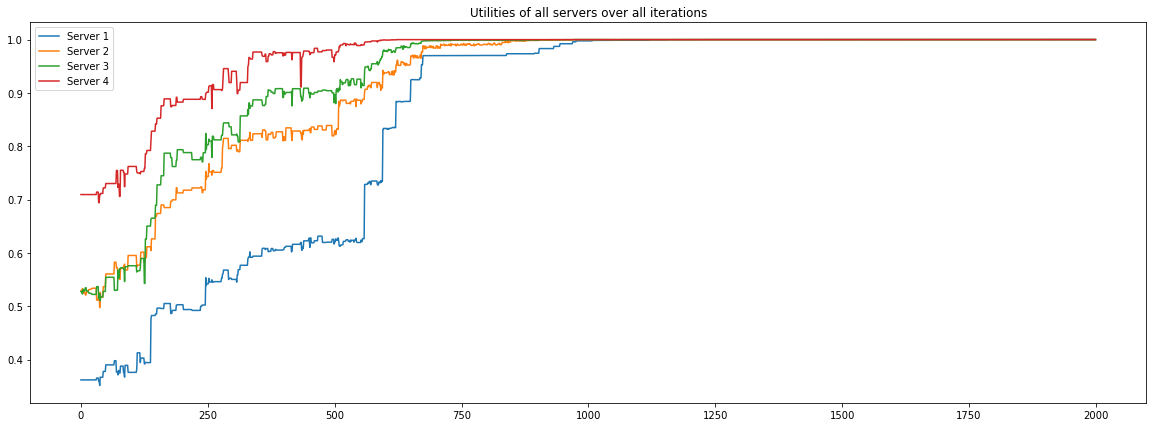

In [55]:
fig, ax1 = plt.subplots(1, 1, figsize=(20, 7))
for srv in range(num_of_servers):
    ax1.plot([util[srv] for util in utilities_01])
ax1.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax1.set_title("Utilities of all servers over all iterations");

In [56]:
all_states = abg.markov.build_states(
    threshold=threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity
)

In [60]:
for srv in range(1, num_of_servers + 1):
    server_mean_weighted_rates = []
    for itr in range(len(reconstructed_rates)):
        current_iteration_mean_weighted_rate = 0
        for state in all_states:
            print(itr, srv, state)
            current_iteration_mean_weighted_rate += (
                reconstructed_rates[itr][srv][state] * reconstructed_state_probabilities[state]
            )
        server_mean_weighted_rates.append(current_iteration_mean_weighted_rate)
    ax2.plot(server_mean_weighted_rates)
ax2.legend([f"Server {srv}" for srv in range(1, num_of_servers + 1)])
ax2.set_title("Weighted mean rates of all servers over all iterations")


0 1 (0, 0)


KeyError: (0, 0)

In [82]:
reconstructed_state_probabilities[86]

array([[1.36364156e-01, 2.48754318e-01, 2.48033534e-01, 1.78238687e-01,
        8.53411729e-02, 4.35657750e-02, 2.75623821e-02, 1.46156889e-02,
        1.81747656e-03, 4.18501853e-04, 3.99290982e-05],
       [           nan,            nan,            nan,            nan,
                   nan,            nan,            nan, 8.89725390e-03,
        7.25838500e-04,            nan,            nan],
       [           nan,            nan,            nan,            nan,
                   nan,            nan,            nan, 3.06300252e-03,
        6.13136070e-04, 1.49403294e-05, 2.91097363e-04],
       [           nan,            nan,            nan,            nan,
                   nan,            nan,            nan, 7.47466836e-04,
        2.99334127e-04, 2.84333742e-05, 4.61266203e-05],
       [           nan,            nan,            nan,            nan,
                   nan,            nan,            nan, 3.08910464e-04,
        1.64883764e-04, 4.79546907e-05,            n

In [45]:
rates_from_file_01[0][3][0]

[0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.4557448793333834,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7,
 0.7]

## Compact rates

In [104]:
def read_rates_new_method(filename):
    server_1_rates = []
    server_2_rates = []
    server_3_rates = []
    server_4_rates = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:

            num_of_states = len(row) / 4
            if int(num_of_states) == num_of_states:
                num_of_states = int(num_of_states)
            else:
                raise Exception("Number of states is not an integer")
                
            server_1_rates.append(
                [float(i.replace('[', '').replace(']', '')) 
                for i in row[:num_of_states]]
            )
            server_2_rates.append(
                [float(i.replace('[', '').replace(']', '')) 
                for i in row[num_of_states:(2 * num_of_states)]]
            )
            server_3_rates.append(
                [float(i.replace('[', '').replace(']', '')) 
                for i in row[(2 * num_of_states):(3 * num_of_states)]]
            )
            server_4_rates.append(
                [float(i.replace('[', '').replace(']', '')) 
                for i in row[(3 * num_of_states):]]
            )
    return server_1_rates, server_2_rates, server_3_rates, server_4_rates


In [106]:
utilities_012 = read_from_file("base_scripts/results/e0.12/utilities.csv")
rates_from_file_012 = read_rates_new_method('base_scripts/results/e0.12/rates.csv')
state_probs_from_file_012 = read_states('base_scripts/results/e0.12/state_probs.csv')

In [156]:
demo = []
for v in range(system_capacity + 1):
    for u in range(buffer_capacity + 1):
        if v >= threshold or u == 0:
            demo.append((u, v))

In [157]:
for i, state in enumerate(all_states):
    print(demo[i], state)

(0, 0) (0, 0)
(0, 1) (0, 1)
(0, 2) (0, 2)
(0, 3) (0, 3)
(0, 4) (0, 4)
(0, 5) (0, 5)
(0, 6) (0, 6)
(0, 7) (0, 7)
(1, 7) (1, 7)
(2, 7) (2, 7)
(3, 7) (3, 7)
(4, 7) (4, 7)
(5, 7) (5, 7)
(6, 7) (6, 7)
(7, 7) (7, 7)
(0, 8) (0, 8)
(1, 8) (1, 8)
(2, 8) (2, 8)
(3, 8) (3, 8)
(4, 8) (4, 8)
(5, 8) (5, 8)
(6, 8) (6, 8)
(7, 8) (7, 8)
(0, 9) (0, 9)
(1, 9) (1, 9)
(2, 9) (2, 9)
(3, 9) (3, 9)
(4, 9) (4, 9)
(5, 9) (5, 9)
(6, 9) (6, 9)
(7, 9) (7, 9)
(0, 10) (0, 10)
(1, 10) (1, 10)
(2, 10) (2, 10)
(3, 10) (3, 10)
(4, 10) (4, 10)
(5, 10) (5, 10)
(6, 10) (6, 10)
(7, 10) (7, 10)
